# Google maps API

### 1 Load credentials
### 2 get/ load Google Maps API data
### 3 process Gmaps data into tables
### 4 load & process map data (plitical borders....)
### 5 combine Gmaps and municipality data
### 6 plots

 

In [1]:
import yaml
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pickle as pk


from mpl_toolkits.mplot3d import Axes3D
from scipy import spatial
from pandas.io.json import json_normalize
from time import sleep
from scipy.spatial.distance import cdist

## 1 Load credentials

In [2]:
#loading credentials
key_yaml = yaml.load(open('credentials.yml'), Loader=yaml.FullLoader)

## 2 get/ load Google Maps API data

In [3]:
def getAPIContent(url):
    """
    API acces wrapper 
    """
    req = requests.get(url)
    places_json = req.json()
    return {key: places_json[key] for key in places_json.keys() & {'results', 'next_page_token'}}


def get60Locations(searchquery, max_steps = 5):
    """
    automate multi-page API queries
    """

    url = "https://maps.googleapis.com/maps/api/place/textsearch/json?" #just for places API

    # The text string on which to search 
    query = 'query=' + searchquery

    AllResults = {}
    next_page_token = 'startstring'
    step = 0

    #loop as long next_page_token is not empty or max steps is reached
    while bool(next_page_token) & (step < max_steps):
        print('iteration {} of query {}'.format(step,searchquery))
        #print(f'We are in loop nr {step}')
        AllResults[step] = getAPIContent(url + query + '&key=' + key_yaml['key_api'])
        if 'next_page_token' in AllResults[step].keys():
            #print(AllResults[step]['next_page_token'])
            next_page_token = AllResults[step]['next_page_token']
        else: #break in case there is no next_page_token
            next_page_token = '' 

        query = 'pagetoken=' + next_page_token
        #print(f'The current next_page_token is {next_page_token}')
        #print('Next url is:')
        #print(url + query + '&key=' + key_yaml['key_api'])

        #increment step
        step += 1
        sleep(2)
    
    return AllResults

def APIdata2DataFrame(Results):
    """
    Takes the results from the get60Locations and puts them into a nice DataFraem
    """
    # merge the multile request results
    df=pd.concat([ pd.DataFrame(Results[x]['results']) for x in range(len(Results)) ],
                 axis=0,sort=False).reset_index(drop=True)

    # remove non-swiss results
    indexNames = df[ df['formatted_address'].str.contains('Switzerland')==False ].index
    if len(indexNames)>0:
        df.drop(indexNames , inplace=True) # prevent error by drop([])
        df.reset_index(drop=True)

    # extract geolocation infos
    df=df.join(json_normalize(df.geometry))

    # extract the postCode
    df=df.join(df.formatted_address.str.extract(r'(\d{4,4})').rename(columns={0: "Postcode"}).astype(int))
    return df
    

In [4]:
#fetch data
pfile='save.pickle' # local file to save API results
shops=['Migros','Coop','Denner','Aldi','Lidl','Spar','Volg']
ShoppingGuide_raw=[]
# for idx,shop in enumerate(shops):
#     ShoppingGuide_raw.append(get60Locations(shop))
    
# pk.dump( ShoppingGuide_raw, open(pfile, "wb" ) )
ShoppingGuide_raw = pk.load( open( pfile, "rb" ))


## 3 process GMaps data into tables

In [5]:
#making DataFrames
shoppingGuide={x: APIdata2DataFrame(ShoppingGuide_raw[idx]) for idx,x in enumerate(shops)}

### 4 load map data (plitical borders....)

In [6]:
# get gemeindegrenzen data
gfile='../data/sod.sd_quartierteams.json'
with open(gfile) as json_file:
    data = json.load(json_file)
dfg=pd.read_json(gfile)  
# some data wrangling
borders=dfg['features'].apply(pd.Series)['geometry'].apply(pd.Series).iloc[:,1]


### 5 combine Gmaps and municipality data

In [16]:
# caclulate gridded data
xrange=[8.44,8.63]    #grid range
yrange=[47.32,47.44]

n_grid = [1000,1000] # number of grid points
xgrid=np.linspace(xrange[0],xrange[1],n_grid[0])
ygrid=np.linspace(yrange[0],yrange[1],n_grid[1])

[xx,yy]=np.meshgrid(xgrid,ygrid) # make 2d-grid

x2=np.reshape(xx,[np.prod(xx.shape)]) # flatten for cdist function
y2=np.reshape(yy,[np.prod(yy.shape)])


# calculate distances to shops
dists={}
for idx, shop in enumerate(shops):
    print(f'{idx}/{len(shops)-1}',shop)
    shopCoords=shoppingGuide[shop][['location.lng','location.lat']].values

    # This solution is optimal when xy2 is very large
    tree = spatial.cKDTree(shopCoords)
    mindist, minid = tree.query(np.array([ ( x, y ) for x, y in zip(x2,y2)]) )
    dists[shop]=np.reshape(mindist,xx.shape)
print('Done')

0/6 Migros
1/6 Coop
2/6 Denner
3/6 Aldi
4/6 Lidl
5/6 Spar
6/6 Volg
Done


### 5 plots

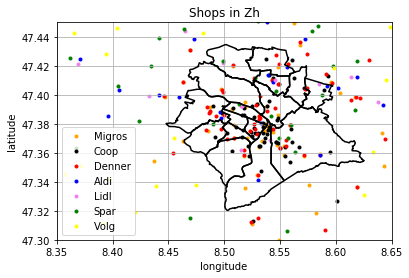

In [17]:
def plotBorders(ax,borders):
    """
    encapsulated the plotting of the political community borders
    """
    borderdata=[]
    for i in range(len(borders)):
        borderdata.append(np.array(borders[i][0]))
        ax.plot(borderdata[i][:,0],
                borderdata[i][:,1],
                c='k')

# plot shops    
colors=['orange','black','red','blue','violet','green','yellow']

fig, ax = plt.subplots()
for idx, shop in enumerate(shops):
    ax.scatter(shoppingGuide[shop]['location.lng'],
               shoppingGuide[shop]['location.lat'], 
               marker='.',
               c=colors[idx],
               label=shop)

ax.set(xlabel='longitude', ylabel='latitude',
           title='Shops in Zh')

plt.xlim(8.35, 8.65)
plt.ylim(47.3, 47.45)

# Gemeindegrenzen
plotBorders(ax,borders)

ax.grid()
ax.legend()
plt.show()

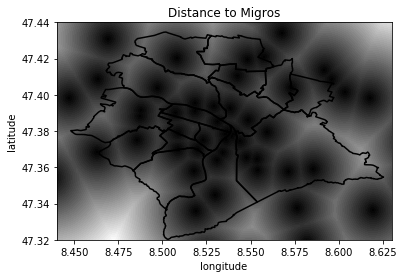

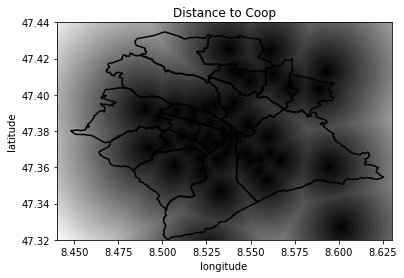

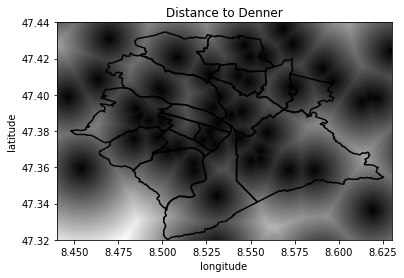

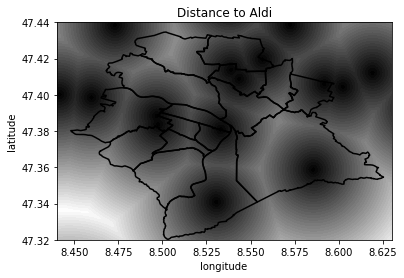

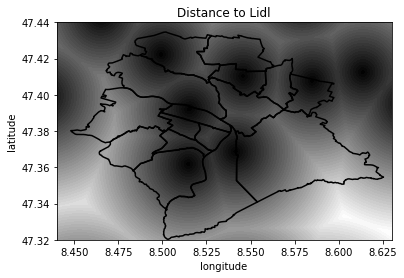

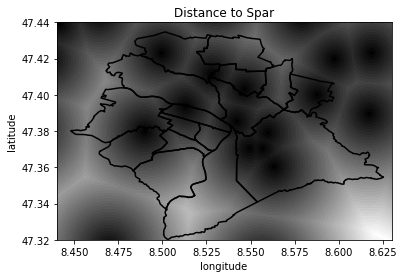

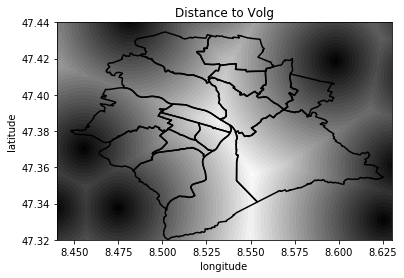

In [19]:
for idx, shop in enumerate(shops):
    fig,ax = plt.subplots()
    ax.contourf(xx, yy, dists[shop], 50,cmap='gray')
    # im = ax.imshow(Z, interpolation='bilinear', cmap='hsv',
    #                origin='lower', 
    #               )# vmax=abs(Z).max(), vmin=-abs(Z).max()
    plotBorders(ax,borders)
    ax.set(xlabel='longitude', ylabel='latitude',
           title=f'Distance to {shop}')
    plt.show()

In [193]:
shoppingGuide['Migros'][['location.lng','location.lat']].values

array([[ 8.5402757, 47.3782609],
       [ 8.5363461, 47.3753409],
       [ 8.544105 , 47.37437  ],
       [ 8.5393233, 47.3771126],
       [ 8.535615 , 47.3784015],
       [ 8.5312265, 47.3852242],
       [ 8.5486894, 47.3860564],
       [ 8.5342194, 47.3682083],
       [ 8.5477979, 47.3654396],
       [ 8.523068 , 47.374944 ],
       [ 8.5594675, 47.3793852],
       [ 8.5384826, 47.3925442],
       [ 8.5537771, 47.3645091],
       [ 8.5309814, 47.3641271],
       [ 8.520124 , 47.3700776],
       [ 8.5292403, 47.3936968],
       [ 8.5087542, 47.3791051],
       [ 8.5539886, 47.3584622],
       [ 8.518553 , 47.391336 ],
       [ 8.517972 , 47.3580873],
       [ 8.507366 , 47.3901133],
       [ 8.508698 , 47.3699516],
       [ 8.5714378, 47.3577127],
       [ 8.5299193, 47.3447661],
       [ 8.4971855, 47.4037541],
       [ 8.5483286, 47.4195319],
       [ 8.5425877, 47.4104989],
       [ 8.5729409, 47.4040166],
       [ 8.5402526, 47.3784248],
       [ 8.518926 , 47.3360383],
       [ 8